# Imports

In [15]:
import numpy as np
import pandas as pd

from scipy.stats import norm, kstest, chi2, t
from matplotlib import pyplot as plt
from statsmodels.distributions import ECDF


Пусть $X_1, X_2, \ldots, X_n$ — выборка из непрерывного распределения.

# Task 1
 - Понять, из какого распределения нам дана эта выборка. Для этого можно построить графики гистограмы и ЭФР и сравнить их с какими-нибудь графиками известных функций распределения. Для этого, например, пригодится вот такая [полезная страничка](https://tvims.nsu.ru/prokopenko/Continious_distribution.html).
 - На этом этапе предполагается, что мы вообще не умеем строить никаких оценок. И тип распределения и его параметры нужно просто угадать. Известно, что все параметры распределения имеют не более одного знака после запятой.
 - После нахождения оценок применить критерий Колмогорова для проверки гипотезы о том, что выборка взята из угаданного распределения.

In [2]:
df = pd.read_excel("../lab2_data.xlsx", index_col=0)
sample = np.array(df['sample'])

In [3]:
sample.shape

(1000000,)

In [4]:


def plot_hist(data, mu=None, sigma=None, title=None):
    """
    Гистограмма по данным data
    Если mu & sigma != None,
    То на гистограмму накладывается соответствующий гауссиан
    """
    data = sorted(data)
    if mu is not None and sigma is not None:
        x = np.linspace(min(data), max(data), num=100000)
        plt.plot(x, norm.pdf(x, loc=mu, scale=sigma), 'r', label=f"N(mu={mu: 0.1f}, sigma={sigma: 0.1f})")

    plt.hist(data, density=True, bins=int(len(data) ** (1 / 2.5)), alpha=0.5, label='Data hist')
    plt.legend()
    plt.xlabel("x")
    plt.ylabel("density")
    if title:
        plt.title(title)
    plt.show()


def plot_pair(data, mu, sigma, title):
    x = np.linspace(min(data), max(data), num=100000)
    ecdf = ECDF(data)
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

    axes[0].step(ecdf.x, ecdf.y, label="Data CDF")
    axes[0].plot(x, norm.cdf(x, loc=mu, scale=sigma), color="r", linestyle="--",
                 label=f"CDF for N(mu={mu: 0.1f}, sigma={sigma: 0.1f})")
    axes[0].set_xlabel('x')
    axes[0].set_ylabel('CDF')
    axes[0].legend()

    bins = int(len(data) ** (1 / 2.5))
    axes[1].hist(data, density=True, bins=bins, alpha=0.5, label='Data hist')
    axes[1].plot(x, norm.pdf(x, loc=mu, scale=sigma), 'r', label=f"N(mu={mu: 0.1f}, sigma={sigma: 0.1f})")
    axes[1].legend()
    axes[1].set_xlabel("x")
    axes[1].set_ylabel("density")

    # fig.tight_layout()
    fig.suptitle(title)
    plt.show()


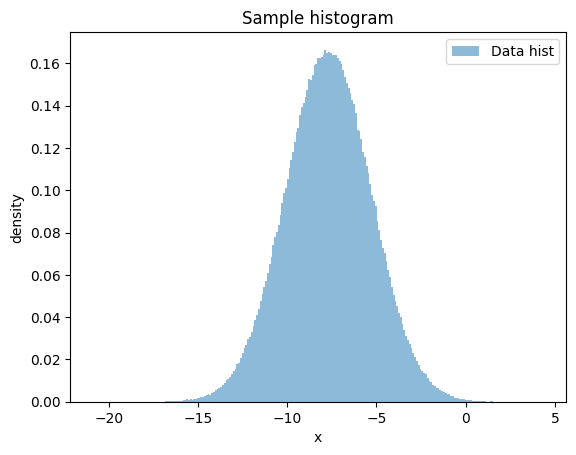

In [5]:
plot_hist(sample, title="Sample histogram")

### Гистограмма очень похожа на нормальное распределение, где $\mu \in (-10, -5),\ \sigma \in (2, 3)$
Выводы насчет $\sigma$ сделал исходя из экспериментов [тут](https://tvims.nsu.ru/prokopenko/Continious_distribution.html)

Подбирая различные mu, sigma с точностью до одного знака после запятой - с помощью kstest-а устанавливаем, что единственная пара параметров, при которой p-value > 0.05 это (-7.7, 2.4) => это единственная гипотеза, которую нельзя отвергнуть.

In [6]:
theoretical_mu, theoretical_sigma = -7.7, 2.4
null_hypothesis = lambda x: norm.cdf(x, theoretical_mu, theoretical_sigma)
kstest(sample, null_hypothesis)

KstestResult(statistic=0.0007067605344556194, pvalue=0.6996747355167738, statistic_location=-4.970161963637683, statistic_sign=1)

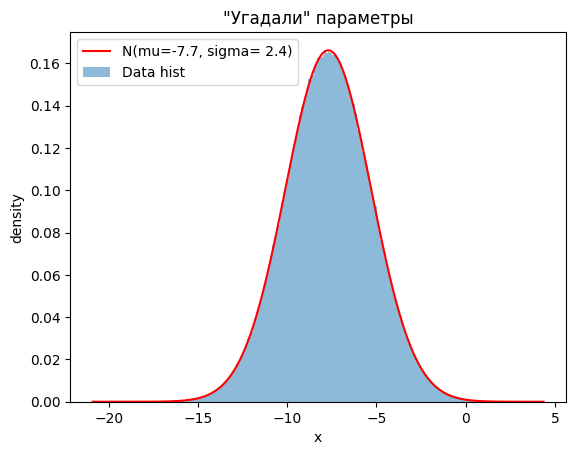

In [7]:
plot_hist(sample, mu=theoretical_mu, sigma=theoretical_sigma, title='"Угадали" параметры')

# Task 2
Построить ОММ (с заданной функцией) и ОМП неизвестных параметров
угаданного распределения. Можно сделать это руками. Можно воспользоваться
встроенными функциями Python. Можно найти их в литературе и использовать.

### Moments method estimation (MME)

$\vec{X} \sim N(\mu, \sigma^2)$ \
$g_1(t) = t$ \
$\mathbf{E}g_1(X) = \mathbf{E}X = \mu$ \
$g_2(t) = t^2$ \
$\mathbf{E}g_2(X) = \mathbf{E}X^2 = \mathbf{D}X + (\mathbf{E}X)^2 = \sigma^2 + \mu^2$ \
$\bar{X} = \mu^*$
$\bar{X^2} = (\sigma^2)^* + (\mu^*)^2 \Rightarrow (\sigma^2)^* = \bar{X^2} - (\bar{X})^2$

In [ ]:
mu_mme, sigma_squared_mme = np.mean(sample), np.mean(sample ** 2) - (np.mean(sample)) ** 2
sigma_mme = sigma_squared_mme ** 0.5

In [99]:
mu_mme, sigma_mme

(-7.700048704901273, 2.398498220677959)

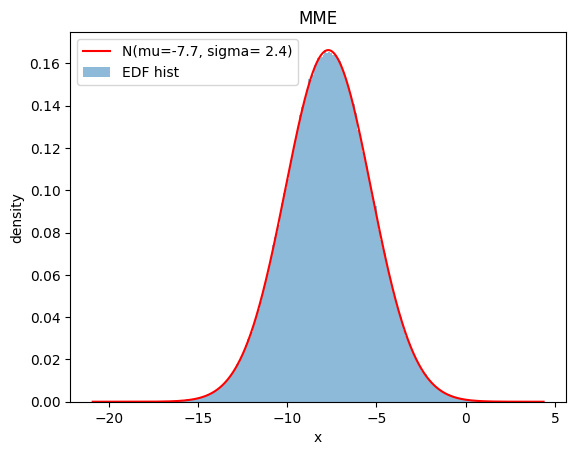

In [14]:
plot_hist(sample, mu=mu_mme, sigma=sigma_mme, title="MME")

### Maximum likelihood estimation (MLE)
Можно получить ОМП путем использования функции ```norm.fit(sample, method="MLE")``` из scipy.
А можно посчитать вручную:

$\vec{X} \sim N(\mu, \sigma^2)$ \
$\theta = (\mu, \sigma^2)$ \
$f_\theta(x) = \frac{1}{\sqrt{2\pi\sigma^2}}\exp(-\frac{(x-\mu)^2}{2\sigma^2})$ \
$\psi(\theta, \vec{X}) = \prod_{i=1}^{n}\frac{1}{\sqrt{2\pi\sigma^2}}\exp(-\frac{(X_i-\mu)^2}{2\sigma^2}) = (2\pi\sigma^2)^{-\frac{n}{2}}\prod_{i=1}^{n}\exp(-\frac{(X_i-\mu)^2}{2\sigma^2})$ \
$L(\theta, \vec{X}) = -\frac{n}{2}\log(2\pi\sigma^2) - \sum_{i=1}^{n} \frac{(X_i-\mu)^2}{2\sigma^2} = -\frac{n}{2}\log(2pi) - n\log(\sigma) - \frac{1}{2\sigma^2}\sum_{i=1}^{n} (X_i-\mu)^2$
$\frac{\partial{L}}{\partial{\mu}} = \frac{2\sum(X_i - \mu)}{2\sigma^2} = \frac{n\bar{X}-n\mu}{\sigma^2} = 0 \ \ (1)$
$\frac{\partial{L}}{\partial{\sigma^2}} = -\frac{n}{2\sigma^2} + \frac{\sum(X_i - \mu)^2}{2\sigma^4} = 0 \ \ (2)$
Решая систему (1)-(2), получим:
$\hat{\mu} = \bar{X}$
$\hat{\sigma^2} = \bar{X^2} - (\bar{X})^2 = s^2$
Заметим, что указанные оценки полностью совпадают с ОММ,
значит далее для этих оценкок будем использовать обозначения:
```mu_sample, sigma_sample = np.mean(sample), (np.mean(sample ** 2) - (np.mean(sample)) ** 2) ** 0.5```

In [15]:
mu_mle, sigme_mle = norm.fit(sample, method="MLE")

In [16]:
mu_mle, sigme_mle

(-7.700048704901273, 2.3984982206779524)

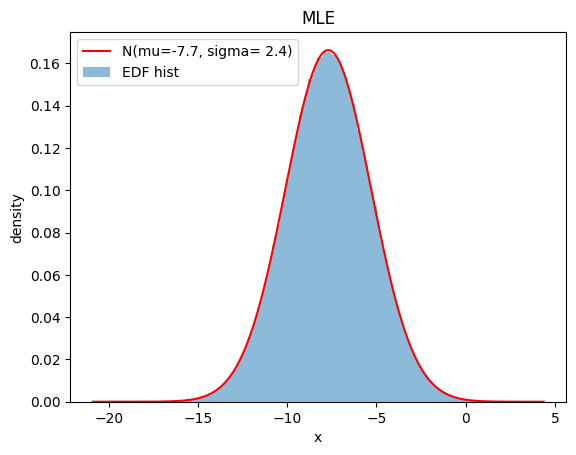

In [17]:
plot_hist(sample, mu=mu_mle, sigma=sigme_mle, title="MLE")

In [8]:
"""
sample: X1, ..., Xn ~ N(mu, sigma^2)
Method of moments estimation (MME) [same as MLE] for normal distribution with arbitary parameters
"""

# mu*
mu_estimation = lambda sample: np.mean(sample)

# sigma*
sigma_estimation = lambda sample: (np.mean(sample ** 2) - (np.mean(sample)) ** 2) ** 0.5

# Task 3
Графически исследовать оценки на состоятельность и асимптотическую нормальность. Сделать это в духе первой лабораторной работы.

## Task 3.a
**Состоятельность**: интересует график, демонстрирующий, сходится ли наша оценка к параметру с ростом объёма выборки. Для этого предлагается последовательно «отрезать» от нашей выборки начальные участки, вычислять по этому участку оценку и отмечать на плоскости точки с координатами (объём начального участка, построенная по нему оценка), соединяя каждую с предыдущей прямой линией. Провести прямые, соответствующие угаданным параметрам.

#### $\mu$ consistency

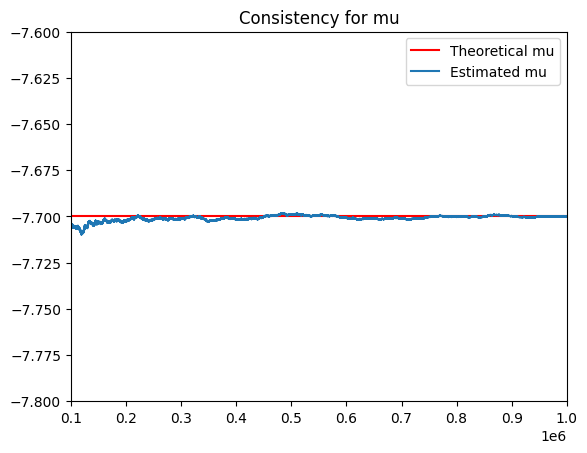

In [9]:
N_s = np.arange(1, len(sample), 1)
estimator = lambda n: mu_estimation(sample[:int(n)])
mu_estimations = [estimator(n) for n in N_s]

plt.xlim(left=100000, right=1000000)
plt.ylim(bottom=-7.8, top=-7.6)
plt.axhline(theoretical_mu, color='red', label="Theoretical mu")
plt.plot(N_s, mu_estimations, label="Estimated mu")
plt.title("Consistency for mu")
plt.legend()
plt.show()

#### $\sigma$ consistency

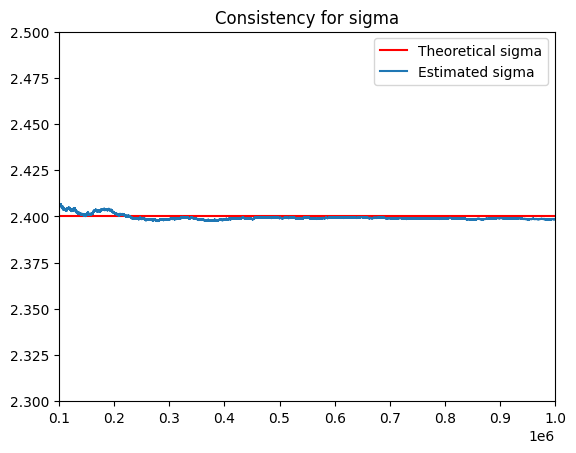

In [10]:
N_s = np.arange(1, len(sample), 1)
estimator = lambda n: sigma_estimation(sample[:int(n)])
sigma_estimations = [estimator(n) for n in N_s]

plt.xlim(left=100000, right=1000000)
plt.ylim(bottom=2.3, top=2.5)
plt.axhline(theoretical_sigma, color='red', label="Theoretical sigma")
plt.plot(N_s, sigma_estimations, label="Estimated sigma")
plt.title("Consistency for sigma")
plt.legend()
plt.show()

## Task 3.b
**Асимптотическая нормальность.** Предлагается разбить данную выборку объёма $10^6$ на $10^3$ объёма $10^3$ . Для каждой из них вычислить значение статистики $\sqrt{n}(\theta^* − \theta)$ и построить гистограмму и ЭФР для получившихся значений статистики. Сравнить их с плотностью и функцией распределения стандартного нормального закона, соответственно. Оценить дисперсию получившейся выборки из значений статистики. Совпадает ли она с коэффициентом асимптотической нормальности?

Проверим на асимптотическую нормальность оценку $\mu^*$:
$\mu^* = \bar{X}$
$\sqrt{n}\frac{\bar{X} - \mu}{\sigma} \Rightarrow N(0, 1)$ по ЦПТ \
$\sqrt{n}(\bar{X} - \mu) = \sqrt{n}\frac{\bar{X} - \mu}{\sigma} \sigma \Rightarrow N(0, \sigma^2)$, где $\sigma=\text{theoretical } \sigma = 2.4 = \sqrt{\text{коэффициент асимптотической нормальности}}$ \
\
Проверим на асимптотическую нормальность оценку $\sigma^*$:
$(\sigma^*)^2 = \bar{X^2} - (\bar{X})^2 = s^2$
На лекциях мы показывали, что: \
$\sqrt{n}\frac{s^2 - \mathbf{D}X}{\sqrt{\mathbf{D}(X-\mathbf{E}X)^2}} \Rightarrow N(0, 1)$ \
А значит $\sqrt{n}((\sigma^*)^2 - \sigma^2) = \sqrt{n}(s^2 - \mathbf{D}X) \Rightarrow N(0, \mathbf{D}(X-\mathbf{E}X)^2)$
$\Rightarrow \text{коэффициент асимптотической нормальности} = \mathbf{D}(X-\mathbf{E}X)^2 = \mathbf{D}Y^2 = \mathbf{E}Y^4 - (\mathbf{E}Y^2)^2\text{, где }Y \sim N(0, \sigma^2) = N(0, 2.4^2)$
Для того, чтобы вычислить к.а.н. будем использовать метод ```norm.moment(order=*some order*, loc=0, scale=2.4)``` из SciPy


В итоге:
$\sigma^2_1(\mu) = \mu \text{ - К.А.Н. для }\mu^*$ \
$\sigma^2_2(\sigma^2) = \sigma^2_2(\mathbf{D}X) = \mathbf{D}(X - \mathbf{E}X)^2 = \mathbf{E}(X-\mathbf{E}X)^4 - (\mathbf{E}({X-\mathbf{E}X})^2)^2 = \mathbf{D}(X^2-2X\mathbf{E}X + const) = \mathbf{D} \text{ - К.А.Н. для }(\sigma^*)^2$

### Вычисляем теоритические коэффициенты асимптотической нормальности для $\mu^*$ и $\sigma^*$

In [42]:
# Coefficient of Asymptotic normality for mu
can4mu = theoretical_sigma ** 2

# Coefficient of Asymptotic normality for sigma
can4sigma = norm.moment(order=4, loc=0, scale=theoretical_sigma) - norm.moment(order=2, loc=0,
                                                                               scale=theoretical_sigma) ** 2

print(f"К.А.Н. для mu: {can4mu}")
print(f"К.А.Н. для sigma: {can4sigma}")

К.А.Н. для mu: 5.76
К.А.Н. для sigma: 66.3552


### Вычисляем практические и сравниваем с теоритическими

In [36]:
partitions = np.split(sample, 10 ** 3)
stat_mu = lambda sample: (len(sample) ** 0.5) * (mu_estimation(sample) - theoretical_mu)
stat_sigma = lambda sample: (len(sample) ** 0.5) * (sigma_estimation(sample) ** 2 - theoretical_sigma ** 2)

stat_sample_mu = [stat_mu(partition) for partition in partitions]
stat_sample_sigma = [stat_sigma(partition) for partition in partitions]



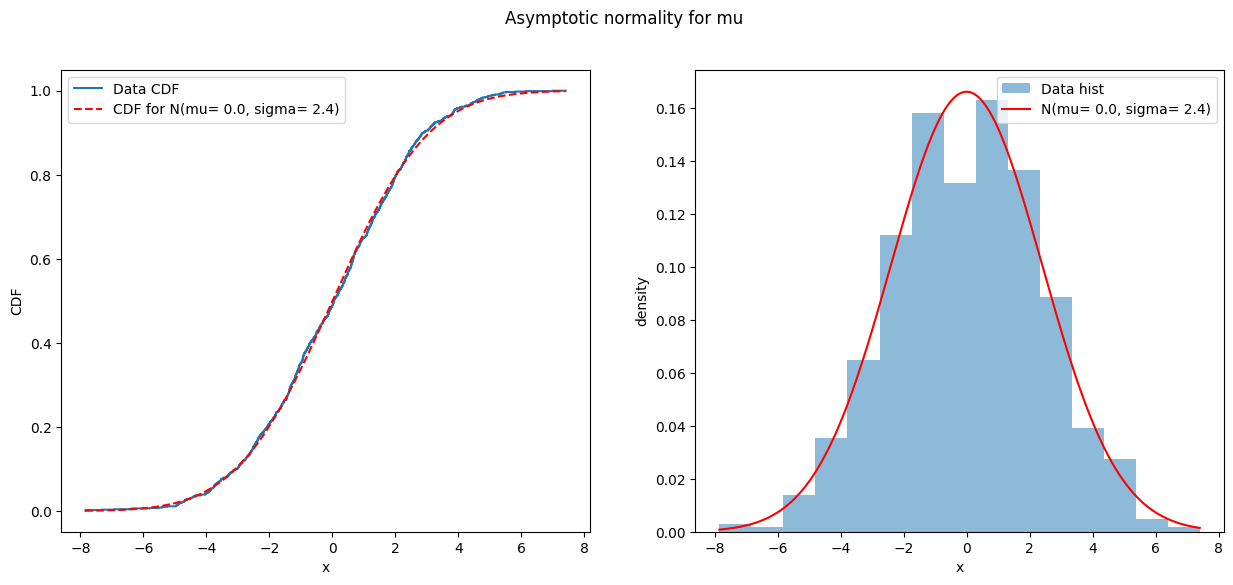

In [60]:
plot_pair(data=stat_sample_mu, mu=0, sigma=can4mu ** 0.5, title="Asymptotic normality for mu")

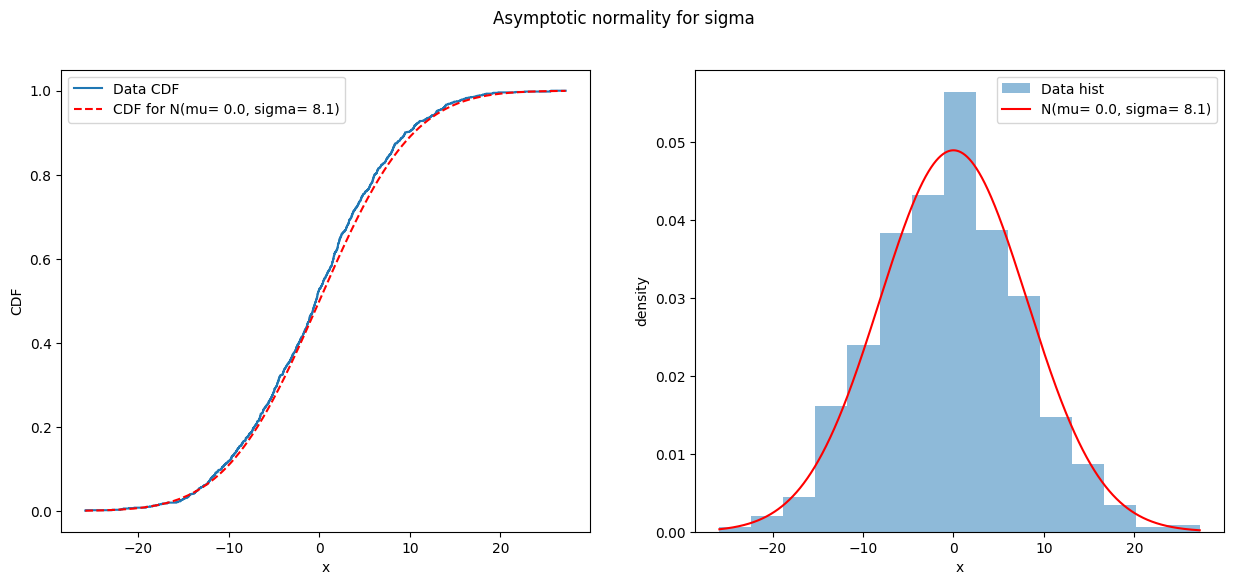

In [61]:
plot_pair(data=stat_sample_sigma, mu=0, sigma=can4sigma ** 0.5, title="Asymptotic normality for sigma")

In [70]:
# Variance comparison

print("Sample from mu statistics")
print(f"Theoretical variance (=К.А.Н.): {can4mu: 0.2f}")
print(f"Practical variance: {np.std(stat_sample_mu) ** 2: 0.2f}")

print()

print("Sample from sigma statistics")
print(f"Theoretical variance (=К.А.Н.): {can4sigma: 0.2f}")
print(f"Practical variance: {np.std(stat_sample_sigma) ** 2: 0.2f}")

Sample from mu statistics
Theoretical variance (=К.А.Н.):  5.76
Practical variance:  5.56

Sample from sigma statistics
Theoretical variance (=К.А.Н.):  66.36
Practical variance:  63.78


Дисперсии mu & sigma ~= К.А.Н.-ам mu & sigma

# Task 4
Построить асимптотические доверительные интервалы уровней доверия 0.95 и 0.99. Рекомендуется использовать теорему о построении асимптотических доверительных интервалов с помощью асимптотически нормальных оценок (нам ведь по крайней мере одна такая оценка известна?).

Вспомним теорему о построении АТДИ:
Если:
1) $\vec{X} \sim F_\theta, \theta \in \Theta$
2) $\theta^*$ - асимптотически нормальная оценка для $\theta$ с коэффициентом асимптотической нормальности $\sigma^2(\theta)$ т.ч. $\sigma(\theta)$ - непр.

Тогда:
- $\theta^+ = \theta^* + \tau_{1-\frac{\varepsilon}{2}}\frac{\sigma(\theta^*)}{\sqrt{n}}$
- $\theta^- = \theta^* - \tau_{1-\frac{\varepsilon}{2}}\frac{\sigma(\theta^*)}{\sqrt{n}}$
- Это АТДИ для $\theta$ уровня доверия $1-\varepsilon$

$(n - 1) s_0^2 = ns^2 = n(\bar{X^2} - \bar{X}^2) \Rightarrow s_0 = \frac{n}{n-1}(\bar{X^2} - \bar{X}^2)$

Воспользуемся полезным следствием леммы Фишера для построения ТДИ (они же АТДИ).

### $\sigma^2$

1) $G(\vec{X}, \sigma^2) = \frac{n}{\sigma^2}s^2 \sim H_{n-1}$
2) $\mathbf{P}(\tau_{\frac{\varepsilon}{2}} < \eta < \tau_{1 - \frac{\varepsilon}{2}}) = 1 - \varepsilon \text{, где } \tau_{\frac{\varepsilon}{2}}, \tau_{1 - \frac{\varepsilon}{2}} = \tau_1, \tau_2$ - квантили распределения хи-квадрат
3) $ \tau_1 < \frac{ns^2}{\sigma^2} < \tau_2 \Rightarrow (\sigma^2)^- = \frac{ns^2}{\tau_2} < \sigma^2 < \frac{ns^2}{\tau_1} = (\sigma^2)^+$ - ТДИ для $\sigma^2$ уровня доверия $1 - \varepsilon$


### $\mu$

1) $G(\vec{X}, \mu) = \sqrt{n} \frac{\bar{X} - \mu}{s_0} \sim T_{n-1}$
2) $\mathbf{P}(\tau_{\frac{\varepsilon}{2}} < \eta < \tau_{1 - \frac{\varepsilon}{2}}) = 1 - \varepsilon \text{, где } \tau_{\frac{\varepsilon}{2}}, \tau_{1 - \frac{\varepsilon}{2}} = \tau_1, \tau_2$ - квантили распределения Стьюдента
3) $ \tau_1 < \sqrt{n} \frac{\bar{X} - \mu}{s_0} < \tau_2 \Rightarrow \mu^- = \bar{X} - \frac{\tau_2s_0}{\sqrt{n}} < \mu < \bar{X} - \frac{\tau_1s_0}{\sqrt{n}} = \mu^+$ - ТДИ для $\mu$ уровня доверия $1 - \varepsilon$

In [19]:
n = len(sample)
s = lambda sample: (np.mean(sample ** 2) - (np.mean(sample)) ** 2) ** 0.5
s0 = lambda sample: (n / (n - 1)) ** 0.5 * s(sample)

In [29]:
PCI_sigma = lambda eps: (n * s(sample) ** 2 / chi2.ppf(q=1 - eps / 2, df=n - 1),
                         n * s(sample) ** 2 / chi2.ppf(q=eps / 2, df=n - 1))
PCI_mu = lambda eps: (mu_estimation(sample) - t.ppf(q=1-eps/2, df=n-1) * s0(sample)/np.sqrt(n),
                      mu_estimation(sample) - t.ppf(q=eps/2, df=n-1) * s0(sample)/np.sqrt(n))


In [35]:
# Уровень доверия = 1 - eps1 = 0.95
eps1 = 0.05
mu_start, mu_end = PCI_mu(eps1)
print(f"(mu-, mu+) = ({mu_start}, {mu_end}) = ТДИ(АТДИ) уровня доверия {1 - eps1}")

# Уровень доверия = 1 - eps2 = 0.99
eps2 = 0.01
mu_start, mu_end = PCI_mu(eps2)
print(f"(mu-, mu+) = ({mu_start}, {mu_end}) = ТДИ(АТДИ) уровня доверия {1 - eps2}")

(mu-, mu+) = (-7.704749683071176, -7.69534772673137) = ТДИ(АТДИ) уровня доверия 0.95
(mu-, mu+) = (-7.706226841784038, -7.693870568018508) = ТДИ(АТДИ) уровня доверия 0.99


In [36]:
# Уровень доверия = 1 - eps1 = 0.95
eps1 = 0.05
sigma_start, sigma_end = PCI_sigma(eps1)
print(f"(sigma^2-, sigma^2+) = ({sigma_start}, {sigma_end}) = ТДИ(АТДИ) уровня доверия {1 - eps1}")

# Уровень доверия = 1 - eps2 = 0.99
eps2 = 0.01
sigma_start, sigma_end = PCI_sigma(eps2)
print(f"(sigma^2-, sigma^2+) = ({sigma_start}, {sigma_end}) = ТДИ(АТДИ) уровня доверия {1 - eps2}")

(sigma^2-, sigma^2+) = (5.7368870474084375, 5.768778489083273) = ТДИ(АТДИ) уровня доверия 0.95
(sigma^2-, sigma^2+) = (5.7318979234487815, 5.773810466932686) = ТДИ(АТДИ) уровня доверия 0.99


In [38]:
print("Theoretical mu: ", theoretical_mu)
print("Theoretical sigma^2: ", theoretical_sigma**2)

Theoretical mu:  -7.7
Theoretical sigma^2:  5.76
